# Wine Quality Prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import numpy as np

In [2]:
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer , OneHotEncoder , MinMaxScaler

In [3]:
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import roc_auc_score , accuracy_score, classification_report , confusion_matrix , ConfusionMatrixDisplay , r2_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [1]:
data_filepath = "Wine_Quality_Prediction\Data\winequalityN.csv"

In [6]:
wine_data = pd.read_csv(data_filepath)
wine_data.head(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [7]:
wine_data.dtypes

type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [8]:
# descriptive stats
wine_data.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6487.0,7.216579,1.296750,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6489.0,0.339691,0.164649,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6494.0,0.318722,0.145265,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6495.0,5.444326,4.758125,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6495.0,0.056042,0.035036,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6488.0,3.218395,0.160748,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6493.0,0.531215,0.148814,0.22000,0.43000,0.51000,0.60000,2.00000


<Axes: title={'center': 'null values in the wine quality dataset'}, xlabel='Features'>

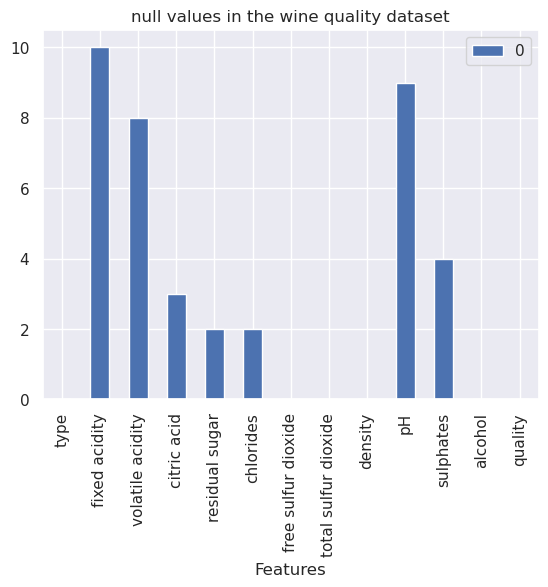

In [9]:
#  NUll values in the dataset
sns.set()
null_values  = pd.DataFrame(wine_data.isnull().sum())
null_values.plot(kind = 'bar' , xlabel = 'Features' , title = 'null values in the wine quality dataset')

In [10]:
#  Replacing null values by mean
for col in wine_data.columns:
    if wine_data[col].isna().sum() > 0:
        wine_data[col] = wine_data[col].fillna(wine_data[col].mean())

In [11]:
wine_data.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

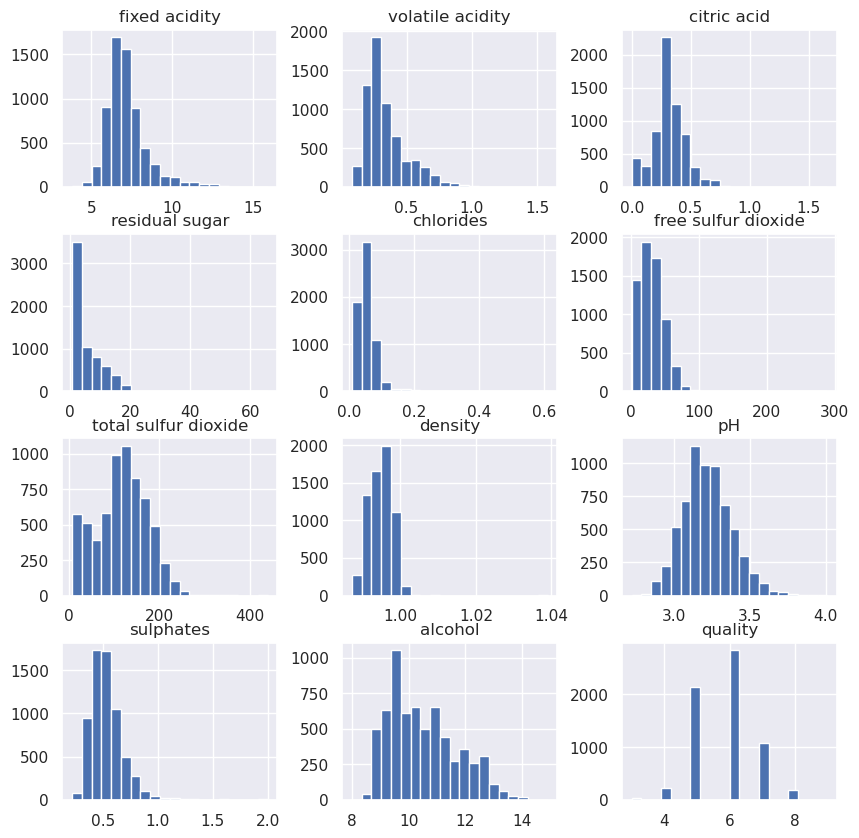

In [12]:
#  Distribution of data
wine_data.hist(bins = 20 , figsize = (10,10))
plt.show()
# We can depict that some of the features in the dataset have skewed distribution

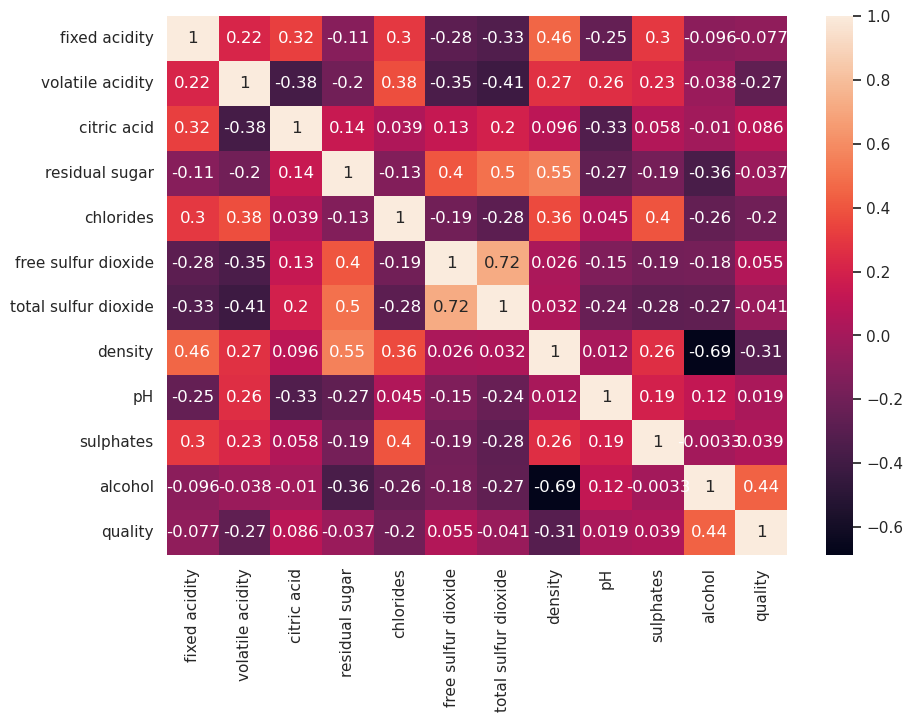

In [13]:
#  We can plot a heatmap to check the how dependent the features are with each other
plt.figure(figsize = (10,7))
sns.heatmap(wine_data.corr() , annot = True)
plt.show()

In [14]:
# We can clearly depict that some of the features are highly correlated so now lets set a threshold of 0.7
# So that we can discard the highly correlated features that would have a sure effect on models performance.

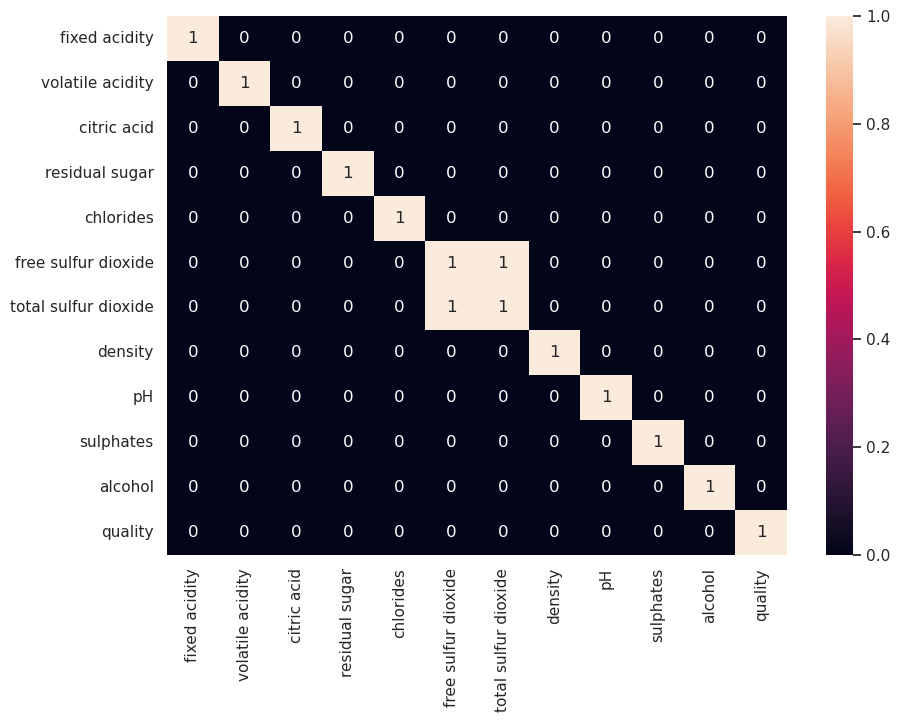

In [15]:
#  Heatmap with the threshold condition
plt.figure(figsize = (10,7))
sns.heatmap(wine_data.corr() > 0.7, annot = True)
plt.show()

In [16]:
# There is a high correlation between 'free sulfur dioxide' &  'total sulfur dioxide' 
#  So we have to remove them as they are not contributing to the model's performance

In [17]:
df = wine_data.drop(columns = 'total sulfur dioxide' , axis  = 1)

In [18]:
df['type'].value_counts()

white    4898
red      1599
Name: type, dtype: int64

In [19]:
df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [20]:
#  Making the response variable binary for classification
df['best_quality'] = [1 if x > 5 else 0 for x in df.quality]

In [21]:
df['best_quality'].unique()

array([1, 0])

In [22]:
X = df.drop(columns = ['quality','best_quality'] , axis = 1)

In [23]:
y = df['best_quality']

In [2]:
# Check class imbalance

In [24]:
X_train , X_test , y_train , y_test = train_test_split(X,y , random_state = 1 , train_size = 0.7 , test_size = 0.3)

In [25]:
print(X_train.shape , X_test.shape)

(4547, 11) (1950, 11)


In [26]:
X_train.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol
863,white,6.2,0.28,0.33,1.7,0.029,24.0,0.9900,3.24,0.50,12.1
104,white,7.4,0.25,0.37,13.5,0.060,52.0,0.9975,3.00,0.44,9.1
1764,white,6.7,0.27,0.25,8.0,0.053,54.0,0.9961,3.22,0.43,9.3
1691,white,7.2,0.25,0.28,14.4,0.055,55.0,0.9986,3.12,0.38,9.0
1344,white,7.3,0.23,0.37,1.9,0.041,51.0,0.9908,3.26,0.40,12.2


In [27]:
X_train1 = pd.DataFrame(X_train.drop(columns = ['type']))
X_train1.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol
863,6.2,0.28,0.33,1.7,0.029,24.0,0.9900,3.24,0.50,12.1
104,7.4,0.25,0.37,13.5,0.060,52.0,0.9975,3.00,0.44,9.1
1764,6.7,0.27,0.25,8.0,0.053,54.0,0.9961,3.22,0.43,9.3
1691,7.2,0.25,0.28,14.4,0.055,55.0,0.9986,3.12,0.38,9.0
1344,7.3,0.23,0.37,1.9,0.041,51.0,0.9908,3.26,0.40,12.2


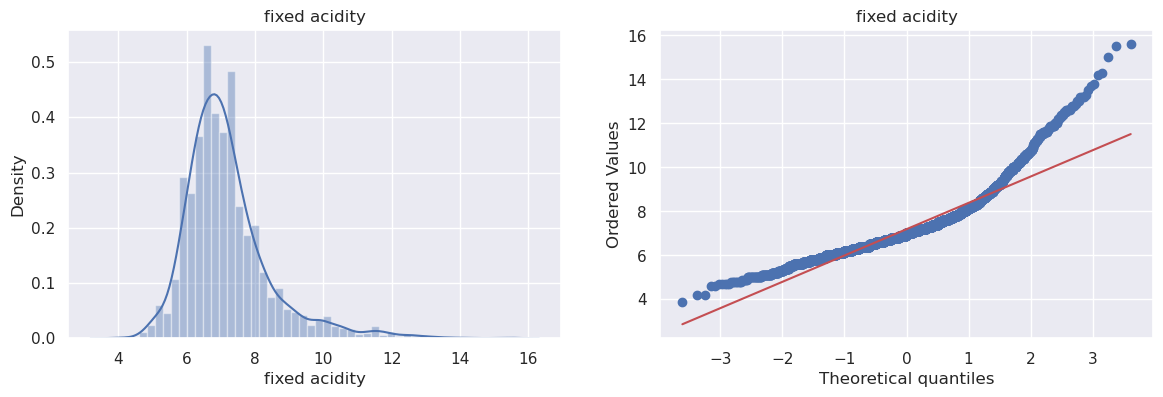

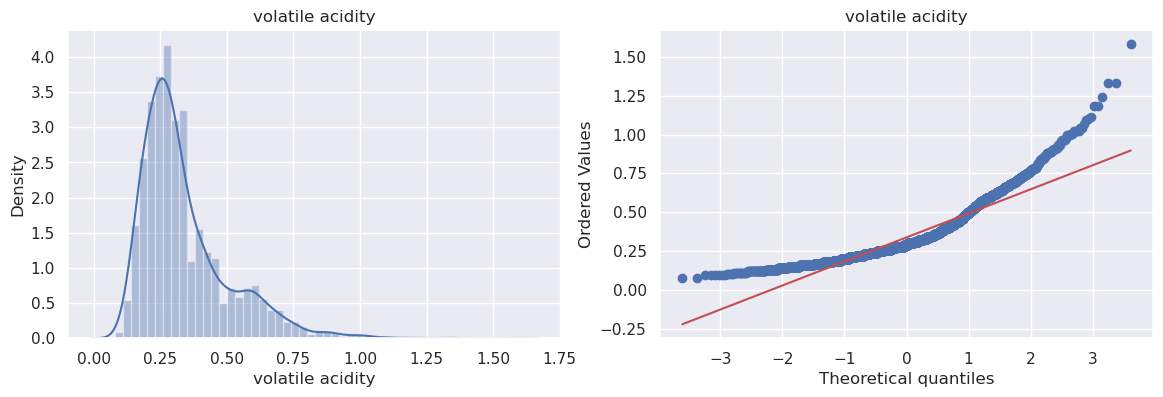

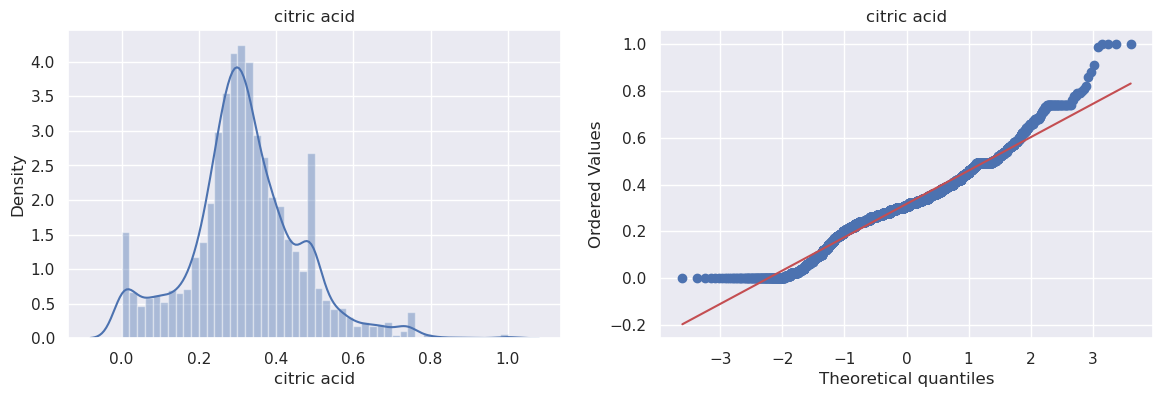

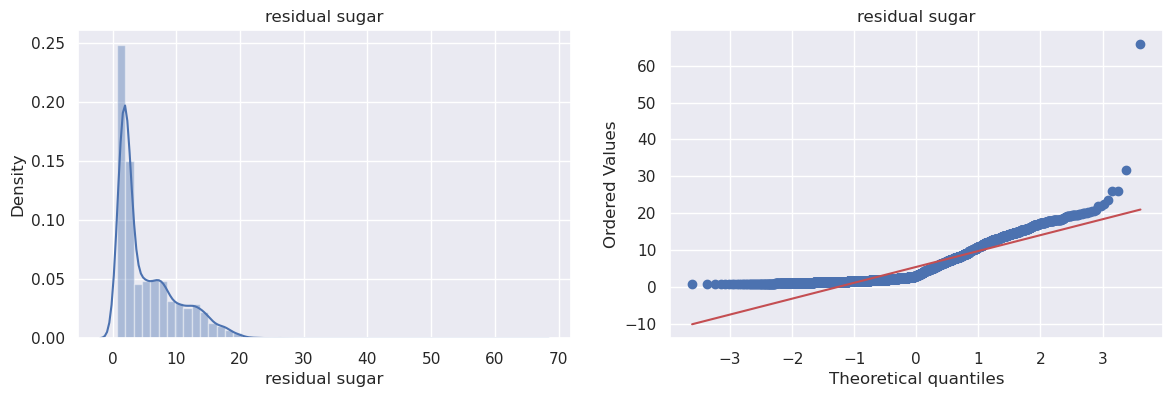

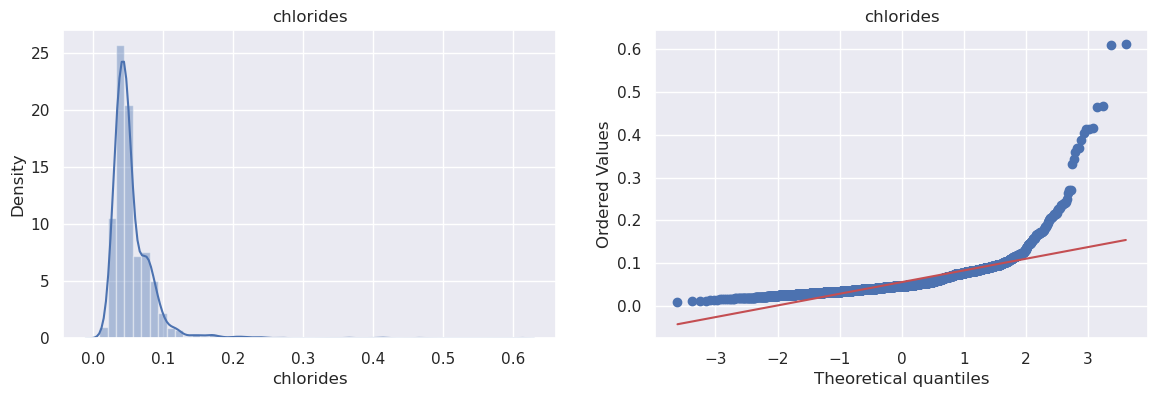

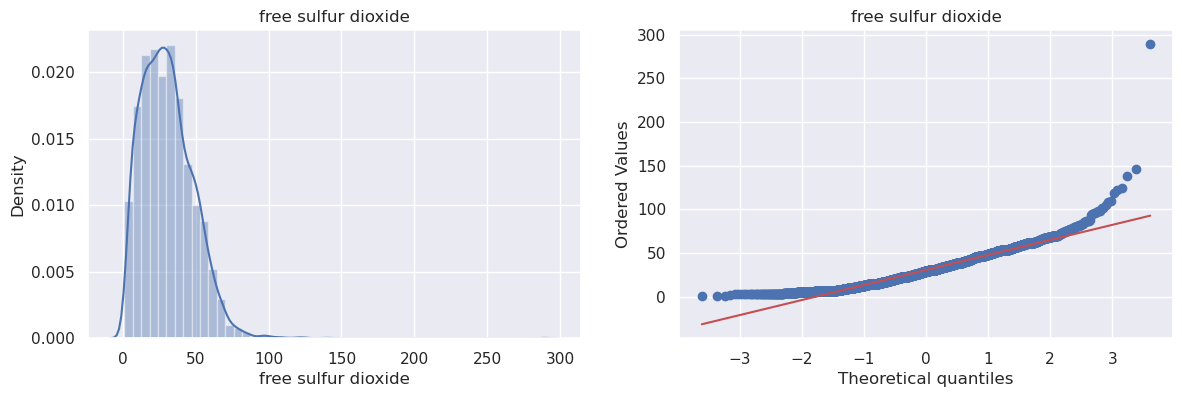

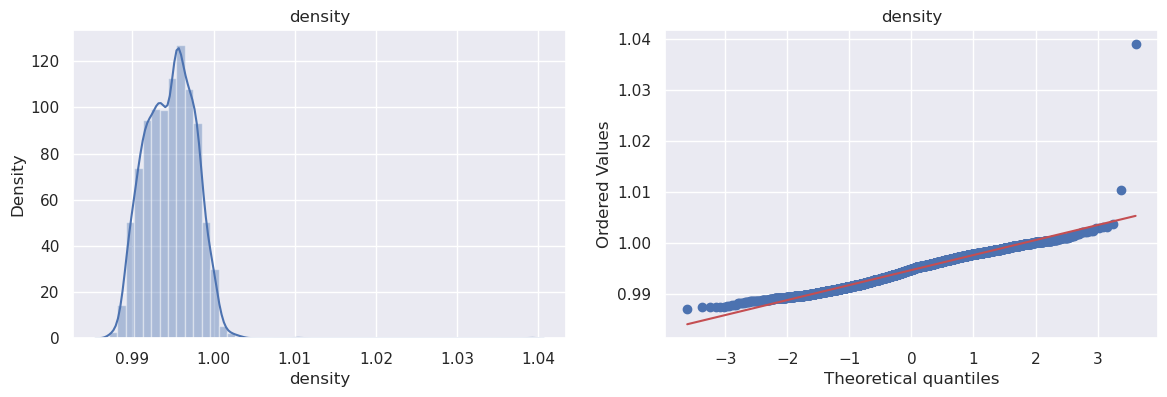

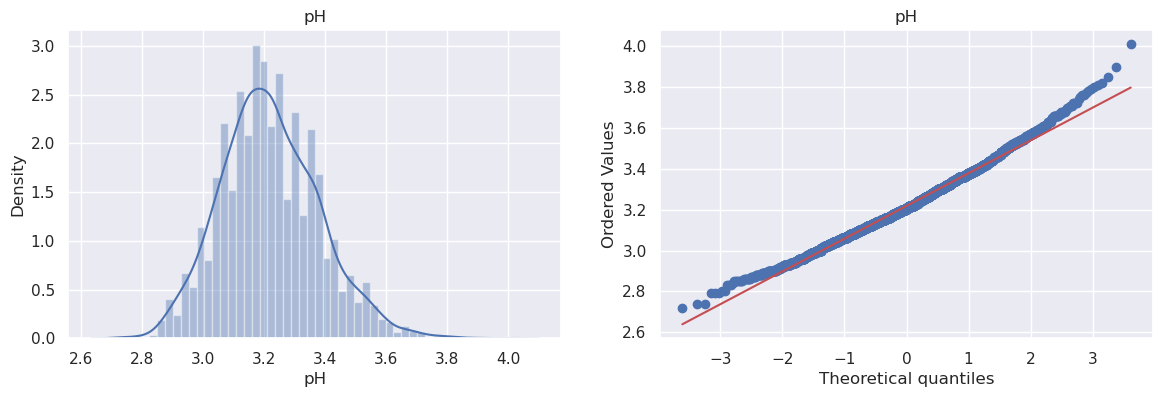

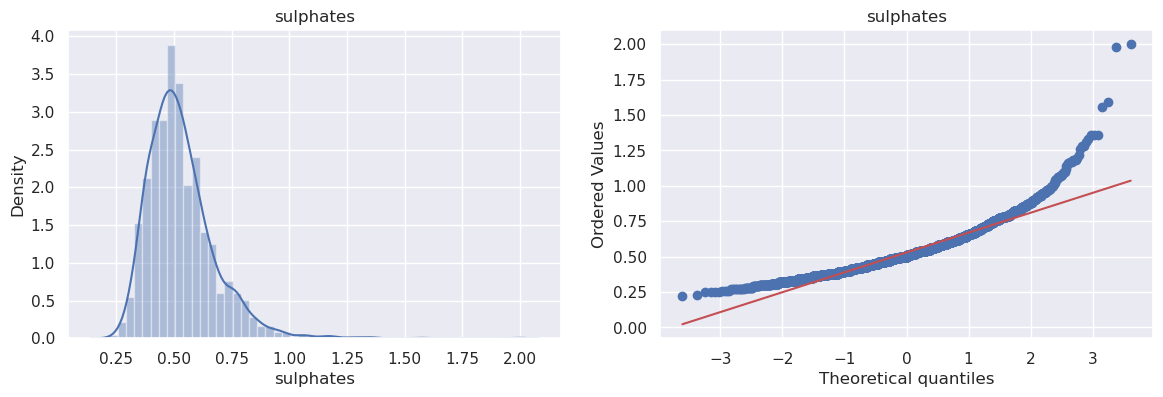

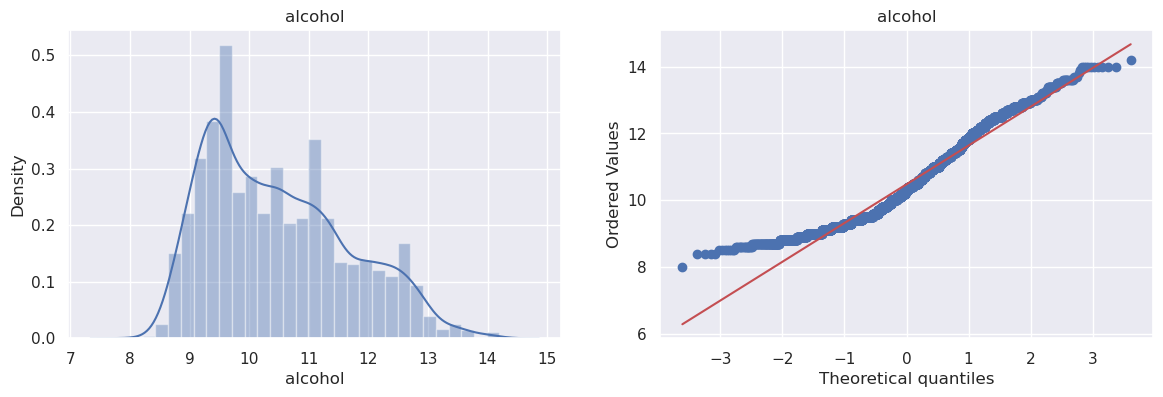

In [28]:
# Plotting the distplots without any transformation
# To know the scale of how skewed the data is we can plot a 
# probability distribution plot that exactly describes what transformations are needed to be performed
for col in X_train1.columns:
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    sns.distplot(X_train1[col])
    plt.title(col)

    plt.subplot(122)
    stats.probplot(X_train1[col], dist="norm", plot=plt)
    plt.title(col)

    plt.show()

In [29]:
transformer1  = ColumnTransformer( transformers = [
    ('Function_Transform' , FunctionTransformer(np.log1p) , ['fixed acidity' , 'volatile acidity' , 'residual sugar','chlorides' , 'free sulfur dioxide','density','sulphates'] ),
    ('OneHotEncoding' , OneHotEncoder(sparse = False) , ['type'])
]  , remainder = 'passthrough')

X_train2 = transformer1.fit_transform(X_train)
X_test2 = transformer1.transform(X_test)

X_train2 = pd.DataFrame(X_train2)
X_test2 = pd.DataFrame(X_test2)

In [32]:
print(X_train2.shape , X_test2.shape)

(4547, 12) (1950, 12)


In [33]:
np.round(X_train2.describe() , 2)

,0,1,2,3,4,5,6,7,8,9,10,11
count,4547.00,4547.00,4547.00,4547.00,4547.00,4547.00,4547.00,4547.00,4547.00,4547.00,4547.00,4547.00
mean,2.09,0.28,1.62,0.05,3.27,0.69,0.42,0.25,0.75,0.32,3.22,10.48
std,0.14,0.12,0.68,0.03,0.65,0.00,0.09,0.43,0.43,0.14,0.16,1.19
min,1.59,0.08,0.53,0.01,0.69,0.69,0.20,0.00,0.00,0.00,2.72,8.00
25%,2.00,0.21,1.03,0.04,2.89,0.69,0.36,0.00,1.00,0.24,3.11,9.50
50%,2.08,0.25,1.39,0.05,3.40,0.69,0.41,0.00,1.00,0.31,3.21,10.30
75%,2.15,0.34,2.21,0.06,3.74,0.69,0.47,0.00,1.00,0.39,3.32,11.30
max,2.81,0.95,4.20,0.48,5.67,0.71,1.10,1.00,1.00,1.00,4.01,14.20


In [34]:
#  Normalising - MinMax Scaler
norm = MinMaxScaler()
X_train3 = norm.fit_transform(X_train2)
X_test3 = norm.transform(X_test2)

X_train3 = pd.DataFrame(X_train3)
X_test3 = pd.DataFrame(X_test3)

In [36]:
np.round(X_train3.describe() , 2)

,0,1,2,3,4,5,6,7,8,9,10,11
count,4547.00,4547.00,4547.00,4547.00,4547.00,4547.00,4547.00,4547.00,4547.00,4547.00,4547.00,4547.00
mean,0.41,0.24,0.30,0.10,0.52,0.15,0.25,0.25,0.75,0.32,0.39,0.40
std,0.12,0.13,0.19,0.06,0.13,0.06,0.10,0.43,0.43,0.14,0.12,0.19
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.34,0.15,0.14,0.06,0.44,0.10,0.18,0.00,1.00,0.24,0.30,0.24
50%,0.40,0.20,0.23,0.08,0.54,0.15,0.23,0.00,1.00,0.31,0.38,0.37
75%,0.46,0.30,0.46,0.12,0.61,0.19,0.30,0.00,1.00,0.39,0.47,0.53
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


# Logistic regression

In [37]:
model2 = LogisticRegression()

In [38]:
model2.fit(X_train3 , y_train)

LogisticRegression()

In [39]:
train_pred2 = model2.predict(X_train3) # Training Set
test_pred2 = model2.predict(X_test3) # Validation Set

In [40]:
print('Accuracy Score:', accuracy_score(y_test , test_pred2))

Accuracy Score: 0.737948717948718


In [41]:
print('Logistic Regression')
print('Accuracy Score :',roc_auc_score(y_train , train_pred2))
print('Validation Score :',roc_auc_score(y_test , test_pred2))

Logistic Regression
Accuracy Score : 0.7158257749115874
Validation Score : 0.6963501297852644


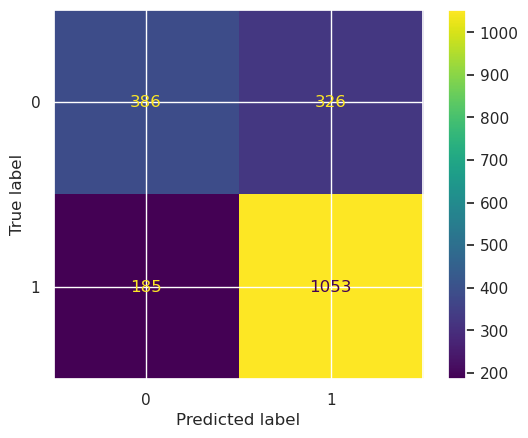

In [42]:
#  Confusion matrix drawn on the validation data
cm1 = confusion_matrix(y_test, test_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()
plt.show()

In [43]:
print(classification_report(y_test , test_pred2))

              precision    recall  f1-score   support

           0       0.68      0.54      0.60       712
           1       0.76      0.85      0.80      1238

    accuracy                           0.74      1950
   macro avg       0.72      0.70      0.70      1950
weighted avg       0.73      0.74      0.73      1950



#  XGboost

In [44]:
model3 = XGBClassifier(random_state = 40)

In [45]:
model3.fit(X_train3 , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=40, ...)

In [46]:
train_pred3 = model3.predict(X_train3) # Training Set
test_pred3 = model3.predict(X_test3) # Validation Set

In [47]:
print('Accuracy Score:', accuracy_score(y_test , test_pred3))

Accuracy Score: 0.8025641025641026


In [48]:
print('XGBClassifier')
print('Accuracy Score :',roc_auc_score(y_train , train_pred3))
print('Validation Score :',roc_auc_score(y_test , test_pred3))

XGBClassifier
Accuracy Score : 0.9830160183066362
Validation Score : 0.7785675064892632


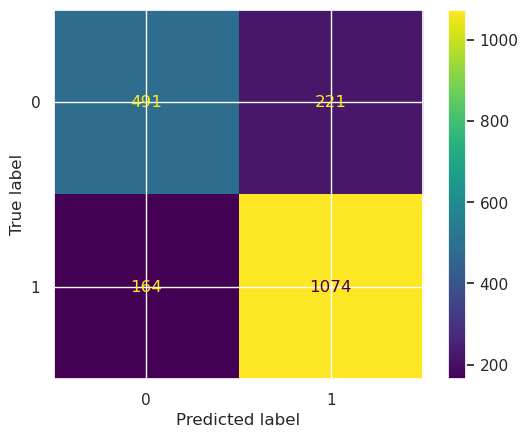

In [49]:
#  Confusion matrix drawn on the validation data
cm2 = confusion_matrix(y_test, test_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp.plot()
plt.show()

In [50]:
print(classification_report(y_test , test_pred3))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       712
           1       0.83      0.87      0.85      1238

    accuracy                           0.80      1950
   macro avg       0.79      0.78      0.78      1950
weighted avg       0.80      0.80      0.80      1950

